In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [357]:
content_img_path = './data/images/000000027755.jpg'
style_img_path = './tie2.jpg'

input_img = cv2.imread(content_img_path)

# desired size of the output image
img_size = 512

In [358]:
input_img_path = './yolov3-master/outputs/000000025797/gradcam/mask_0.jpg'

In [359]:
import PIL.Image as Image
import torchvision.transforms as transforms
img_size = 512


def load_img(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((img_size, img_size))
    img = transforms.ToTensor()(img)
    # 为img增加一个维度：1
    # 因为神经网络的输入为 4 维
    img = img.unsqueeze(0)
    return img

In [360]:
import torch
from torch.autograd import Variable

# 加载风格图片
style_img = load_img(style_img_path)
# 对img进行转换为 Variable 对象，使它能够动态计算梯度
style_img = Variable(style_img).to(device)
# 加载内容图片
content_img = load_img(content_img_path)
content_img = Variable(content_img).to(device)
print(style_img.size(), content_img.size())

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


In [361]:
import torch.nn as nn


class Content_Loss(nn.Module):
    # 其中 target 表示 C ，input 表示 G，alpha 表示 weight 的平方
    def __init__(self, target, weight):
        super(Content_Loss, self).__init__()
        self.weight = weight
        # detach 可以理解为使 target 能够动态计算梯度
        # target 表示目标内容，即想变成的内容
        self.target = target.detach() * self.weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        out = input.clone()
        return out

    def backward(self, retain_variabels=True):
        self.loss.backward(retain_graph=retain_variabels)
        return self.loss

In [362]:
# 损失函数的测试
cl = Content_Loss(content_img, 1)
# 随机图片
rand_img = torch.randn(content_img.data.size(), device=device)
cl.forward(rand_img)
print(cl.loss)

tensor(1.5230)


In [363]:
class Gram(nn.Module):
    def __init__(self):
        super(Gram, self).__init__()

    def forward(self, input):
        a, b, c, d = input.size()
        # 将特征图变换为 2 维向量
        feature = input.view(a * b, c * d)
        # 内积的计算方法其实就是特征图乘以它的逆
        gram = torch.mm(feature, feature.t())
        # 对得到的结果取平均值
        gram /= (a * b * c * d)
        return gram

gram = Gram()
gram

Gram()

In [364]:
#获取风格的test
target = gram(style_img)
# 此时 style_img 的通道为3 所以产生的风格特征为 3×3
target

tensor([[0.0806, 0.0563, 0.0350],
        [0.0563, 0.0398, 0.0253],
        [0.0350, 0.0253, 0.0175]])

In [365]:
class Style_Loss(nn.Module):
    def __init__(self, target, weight):
        super(Style_Loss, self).__init__()
        # weight 和内容函数相似，表示的是权重 beta
        self.weight = weight
        # targer 表示图层目标。即新图像想要拥有的风格
        # 即保存目标风格
        self.target = target.detach() * self.weight
        self.gram = Gram()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        # 加权计算 input 的 Gram 矩阵
        G = self.gram(input) * self.weight
        # 计算真实的风格和想要得到的风格之间的风格损失
        self.loss = self.criterion(G, self.target)
        out = input.clone()
        return out
    # 向后传播

    def backward(self, retain_variabels=True):
        self.loss.backward(retain_graph=retain_variabels)
        return self.loss

In [366]:
#风格损失test

# 传入模型所需参数
sl = Style_Loss(target, 1000)
# 传入一张随机图片进行测试
rand_img = torch.randn(style_img.data.size(), device=device)
# 损失函数层向前传播，进而得到损失
sl.forward(rand_img)
sl.loss

tensor(28857.7129)

In [367]:
import torchvision.models as models
# 设置与预训练模型所在连接
# torch.utils.model_zoo.load_url("https://labfile.oss.aliyuncs.com/courses/861/vgg19_pre.zip")
vgg = models.vgg19(pretrained=True).features
vgg = vgg.to(device)

In [368]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
# 初始化一个 空的神经网络 model
model = nn.Sequential()
model = model.to(device)
# 构造网络模型，并且返回这些损失函数


def get_style_model_and_loss(style_img, content_img, cnn=vgg, style_weight=1000, content_weight=1,
                             content_layers=content_layers_default,
                             style_layers=style_layers_default):
    # 用列表来存上面6个损失函数
    content_loss_list = []
    style_loss_list = []

    # 风格提取函数
    gram = Gram()
    gram = gram.to(device)

    i = 1
    # 遍历 VGG19 ，找到其中我们需要的卷积层
    for layer in cnn:
        # 如果 layer 是  nn.Conv2d 对象，则返回 True
        # 否则返回 False
        if isinstance(layer, nn.Conv2d):
            # 将该卷积层加入我们的模型中
            name = 'conv_' + str(i)
            model.add_module(name, layer)

            # 判断该卷积层是否用于计算内容损失
            if name in content_layers_default:
                # 这里是把目标放入模型中，得到该层的目标
                target = model(content_img)
                # 目标作为参数传入具体的损失类中，得到一个工具函数。
                # 该函数可以计算任何图片与目标的内容损失
                content_loss = Content_Loss(target, content_weight)
                model.add_module('content_loss_' + str(i), content_loss)
                content_loss_list.append(content_loss)

            # 和内容损失相似，不过增加了一步：提取风格
            if name in style_layers_default:
                target = model(style_img)
                target = gram(target)
                # 目标作为参数传入具体的损失类中，得到一个工具函数。
                # 该函数可以计算任何图片与目标的风格损失
                style_loss = Style_Loss(target, style_weight)
                model.add_module('style_loss_' + str(i), style_loss)
                style_loss_list.append(style_loss)

            i += 1
        # 对于池化层和 Relu 层我们直接添加即可
        if isinstance(layer, nn.MaxPool2d):
            name = 'pool_' + str(i)
            model.add_module(name, layer)

        if isinstance(layer, nn.ReLU):
            name = 'relu' + str(i)
            model.add_module(name, layer)
    # 综上：我们得到了：
    # 一个具体的神经网络模型，
    # 一个风格损失函数集合（其中包含了 5 个不同风格目标的损失函数）
    # 一个内容损失函数集合（这里只有一个，你也可以多定义几个）
    return model, style_loss_list, content_loss_list

In [369]:
model, style_loss_list, content_loss_list = get_style_model_and_loss(
    style_img, content_img)

In [370]:
import torch.optim as optim


def get_input_param_optimier(input_img):
    # 将input_img的值转为神经网络中的参数类型
    input_param = nn.Parameter(input_img.data)
    # 告诉优化器，我们优化的是 input_img 而不是网络层的权重
    # 采用 LBFGS 优化器
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer


# 输入一个随机图片进行测试
get_input_param_optimier(rand_img)

(Parameter containing:
 tensor([[[[-1.0737, -0.3167, -1.5677,  ..., -1.7196, -0.0385, -1.5220],
           [ 0.5865, -0.5131, -0.1686,  ...,  1.9405, -1.6574,  0.9068],
           [-0.4637,  0.9416, -2.1730,  ...,  0.2319, -0.6023,  0.5911],
           ...,
           [ 0.3276, -2.3474,  0.1974,  ..., -1.4388, -1.5444, -0.9368],
           [ 0.4713, -0.8137, -0.2156,  ..., -0.1066, -0.0965,  1.2836],
           [-0.3607,  1.3876,  0.5513,  ..., -0.0894,  1.0507, -1.3318]],
 
          [[ 1.1426,  0.0723, -1.1003,  ..., -0.5928, -1.9811, -0.5063],
           [ 0.1212, -1.0307,  2.0538,  ...,  1.0001, -0.3656, -0.5849],
           [ 0.1020, -0.7113, -0.0851,  ..., -2.2411,  0.1727,  1.2671],
           ...,
           [ 0.2143,  1.2847,  0.1141,  ..., -0.2439, -0.8440,  0.0945],
           [-0.6231, -0.0475,  0.0941,  ..., -0.0643, -0.0682,  0.6906],
           [-1.1067, -0.4944,  0.7901,  ...,  0.0570,  1.4286,  0.2678]],
 
          [[ 1.3512, -0.9382, -0.7830,  ...,  0.8383,  0.1381, 

In [371]:
# 传入的 input_img 是 G 中每个像素点的值，可以为一个随机图片
def run_style_transfer(content_img, style_img, input_img, num_epoches):
    print('Building the style transfer model..')
    # 指定所需要优化的参数，这里 input_param就是G中的每个像素点的值
    input_param, optimizer = get_input_param_optimier(input_img)

    print('Opimizing...')
    epoch = [0]
    while epoch[0] < num_epoches:
        # 这里我们自定义了总损失的计算方法
        def closure():
            input_param.data.clamp_(0, 1)  # 更新图像的数据
            # 将此时的 G 传入模型中，得到每一个网络层的输出
            model(input_param)
            style_score = 0
            content_score = 0
            # 清空之前的梯度
            optimizer.zero_grad()
            # 计算总损失，并得到各个损失的梯度
            for sl in style_loss_list:
                style_score += sl.backward()
            for cl in content_loss_list:
                content_score += cl.backward()

            epoch[0] += 1
            # 这里每迭代一次就进行一次输出
            # 你可以根据自身情况进行调节
            if epoch[0] % 1 == 0:
                print('run {}/80'.format(epoch))
                print('Style Loss: {:.4f} Content Loss: {:.4f}'.format(
                    style_score.data.item(), content_score.data.item()))
                print()

            return style_score + content_score
        # 更新 G
        optimizer.step(closure)
    # 返回训练完成的 G，此时的 G
    return input_param.data

In [372]:
# 初始化 G
input_img = content_img.clone()
# 进行模型训练，并且返回图片
out = run_style_transfer(content_img, style_img, input_img, num_epoches=80)
# 将图片转换成可 PIL 类型，便于展示
new_pic = transforms.ToPILImage()(out.cpu().squeeze(0))
print("训练完成")

Building the style transfer model..
Opimizing...
run [1]/80
Style Loss: 369.0766 Content Loss: 0.0000

run [2]/80
Style Loss: 369.0395 Content Loss: 0.0000

run [3]/80
Style Loss: 246.2698 Content Loss: 0.4639

run [4]/80
Style Loss: 147.8764 Content Loss: 1.4355

run [5]/80
Style Loss: 101.8112 Content Loss: 2.5964

run [6]/80
Style Loss: 63.9584 Content Loss: 2.6229

run [7]/80
Style Loss: 39.8583 Content Loss: 2.5866

run [8]/80
Style Loss: 27.9100 Content Loss: 2.7116

run [9]/80
Style Loss: 22.5126 Content Loss: 2.7949

run [10]/80
Style Loss: 18.8855 Content Loss: 3.0273

run [11]/80
Style Loss: 16.6390 Content Loss: 3.0770

run [12]/80
Style Loss: 14.6889 Content Loss: 3.1686

run [13]/80
Style Loss: 13.1897 Content Loss: 3.2177

run [14]/80
Style Loss: 11.9338 Content Loss: 3.2503

run [15]/80
Style Loss: 10.7052 Content Loss: 3.3078

run [16]/80
Style Loss: 9.7075 Content Loss: 3.3492

run [17]/80
Style Loss: 9.5321 Content Loss: 3.4293

run [18]/80
Style Loss: 9.2265 Content 

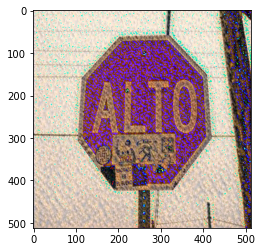

In [373]:
import matplotlib.pyplot as plt  # plt 用于显示图片
%matplotlib inline
# 展示图片
plt.imshow(new_pic)